# Análise - Healthcare

* O dataset consiste em 10 mil registros, cada um representando um registro de pacient sintético de saúde.
* Inclui uma variedade de atributos, como:

  * __Name__: Representa o nome do paciente associado com seus registros de saúde.
  * __Age__: A idade do paciente na hora da admissão, explicíta em anos.
  * __Gender__: Indica o sexo do paciente: _Masculino_ ou _Feminino_.
  * __Blood Type__: Tipo de sangue do paciente, sendo: _A+_, _O-_, etc.
  * __Medical Conditions__: Essa coluna especifica medicamento diário ou diagnósticos associados ao paciente
  * __Date of Admission__: A data na qual o paciente teve a ficha registrada no estabelecimento de saúde.
  * __Doctor__: O nome do profissional responsável pelo atendimento do paciente.
  * __Hospital__: Identifica o estabelecimento de saúde ou hospital onde o paciente foi atendido.
  * __Insurance Provider__: Indica o tipo de plano de saúde aderido pelo paciente.
  * __Billing Amount__: A quantia de dinheiro cobrada pelos serviços de saúde ao paciente.
  * __Room Number__: O número do quarto onde o paciente ficou acomodado.
  * __Admission Type__: Especifica o tipo de admissão, que pode ser: _Emergency_, _Elective_, _Urgent_, refletindo as circunstâncias da admissão.
  * __Discharge Date__: A data na qual o paciente foi dispensado do estabelecimento, baseado na data de admissão e um número aleatório de dias.
  * __Medication__: Identifica a medicação prescrita ou administrada para o paciente
  * __Test Results__: Descreve o resultado do exame médico conduzido. Possíveis valores incluem: _Normal_, _Anormal_ ou _Inconclusivo_.

O dataset é dedicado para uso de deducação e uso não-comercial, logo é inteiramente sintético e não contém  
dados reais de paciente.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from scipy.stats import trim_mean
from statsmodels import robust
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score
from yellowbrick.classifier import ConfusionMatrix
from datetime import datetime
import warnings
import os

In [2]:
warnings.filterwarnings('ignore')
print(f'Inicio: {str(datetime.now().strftime('%Y-%m-%d'))}')

Inicio: 2025-09-19


In [3]:
folder_name = os.path.basename('csv files')
file_name = f'healthcare_dataset.csv'

if os.path.exists(folder_name) and os.path.isdir(folder_name):
    try:
        components = np.array([os.getcwd(), folder_name, file_name])
        full_path = os.path.join(*np.concatenate(components.reshape(-1, 1)))
    except Exception as e:
        raise NotADirectoryError(f'Folder is not a directory. Please check again')

df = pd.read_csv(
    full_path,
    encoding='utf-8',
    na_filter=False,
    verbose=0,
    thousands='|',
    float_precision='legacy'
)

df.head()

,Name,Age,Gender,Blood Type,Medical Condition,Date of Admission,Doctor,Hospital,Insurance Provider,Billing Amount,Room Number,Admission Type,Discharge Date,Medication,Test Results
0,Bobby JacksOn,30,Male,B-,Cancer,2024-01-31,Matthew Smith,Sons and Miller,Blue Cross,18856.281306,328,Urgent,2024-02-02,Paracetamol,Normal
1,LesLie TErRy,62,Male,A+,Obesity,2019-08-20,Samantha Davies,Kim Inc,Medicare,33643.327287,265,Emergency,2019-08-26,Ibuprofen,Inconclusive
2,DaNnY sMitH,76,Female,A-,Obesity,2022-09-22,Tiffany Mitchell,Cook PLC,Aetna,27955.096079,205,Emergency,2022-10-07,Aspirin,Normal
3,andrEw waTtS,28,Female,O+,Diabetes,2020-11-18,Kevin Wells,"Hernandez Rogers and Vang,",Medicare,37909.782410,450,Elective,2020-12-18,Ibuprofen,Abnormal
4,adrIENNE bEll,43,Female,AB+,Cancer,2022-09-19,Kathleen Hanna,White-White,Aetna,14238.317814,458,Urgent,2022-10-09,Penicillin,Abnormal


In [4]:
try:
    df['Discharge Date'] = df['Discharge Date'].apply(
        lambda y: pd.to_datetime(y, format='%Y-%m-%d', yearfirst=True, errors=f'coerce')
    )
    df['Date of Admission'] = df['Date of Admission'].apply(
        lambda y: pd.to_datetime(y, format='%Y-%m-%d', yearfirst=True, errors=f'coerce')
    )
except TypeError as e:
    print(f'Descrição do erro: {e}')

In [5]:
# Corrigir os caracteres dos nomes dos paciente

def fix_patient_names(names):
    words = names.strip().lower().split()
    format_names = []

    for i, word in enumerate(words):
        if i > 0 and word in df['Name'].values:
            format_names.append(word)
        else:
            format_names.append(word.capitalize())

    return ' '.join(format_names)

In [6]:
df.Name = df['Name'].apply(fix_patient_names)

In [7]:
df['Name'].where(df.index <= 10)

0        Bobby Jackson
1         Leslie Terry
2          Danny Smith
3         Andrew Watts
4        Adrienne Bell
             ...      
55495              NaN
55496              NaN
55497              NaN
55498              NaN
55499              NaN
Name: Name, Length: 55500, dtype: object

In [8]:
df.drop_duplicates(keep='first', inplace=True)

In [9]:
from typing import Optional, Union, Dict
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def filter_na_values(
    x:pd.DataFrame,
    show:bool=True,
    return_as:str='dict',
    log:bool=False
) -> Optional[Union[Dict[str, float], pd.Series]]:

    na_values = [cname for cname in x.columns if np.count_nonzero(x.isna().sum()) > 0]

    if not na_values:
        message = f'NaN values not found'
        if log:
            logger.info(message)
        elif show:
            print(message)
        return message

    message = f'Null columns found:\n {na_values}'

    if log:
        logger.warning(message)
    elif show:
        print(message)

    if return_as == 'dict':
        return na_values.to_dict()
    elif return_as == 'series':
        return na_values
    else:
        raise ValueError("Parâmetro 'return_as' deve ser 'dict' ou 'series'")

In [10]:
outcome = filter_na_values(df, True, 'series', False)

NaN values not found


In [11]:
df['Billing Amount'].describe().apply(lambda y: format(y, 'f')).reset_index()

,index,Billing Amount
0,count,54966.000000
1,mean,25544.306284
2,std,14208.409711
3,min,-2008.492140
4,25%,13243.718641
5,50%,25542.749145
6,75%,37819.858159
7,max,52764.276736


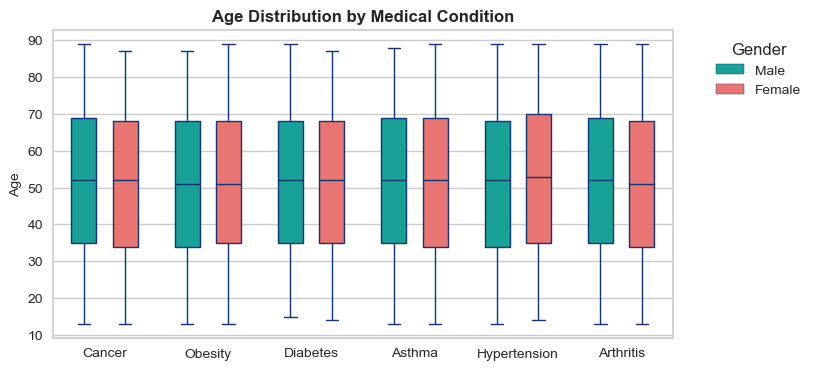

In [12]:
colors = ['#01B8AA', '#FD625E']

fig, ax = plt.subplots(figsize=(8, 4))
sns.boxplot(data=df, x='Medical Condition', y='Age', palette=colors, 
            hue='Gender', gap=.4, ax=ax, linecolor='#137')

ax.set_title(f'Age Distribution by Medical Condition', fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Gender', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel(f'Age', fontsize=10)
plt.show()

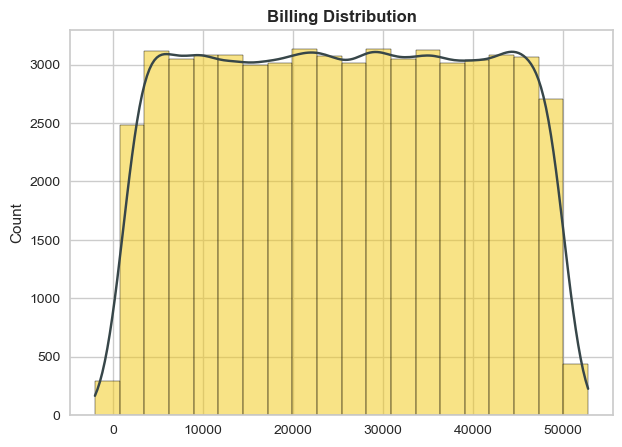

In [13]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.histplot(data=df, x='Billing Amount', kde=True, bins=20, color='#F2C80F', ax=ax)

ax.lines[0].set_color('#374649')
ax.set_title(f'Billing Distribution', fontweight='bold')
plt.xlabel('')

plt.show()

## Examina Normalização

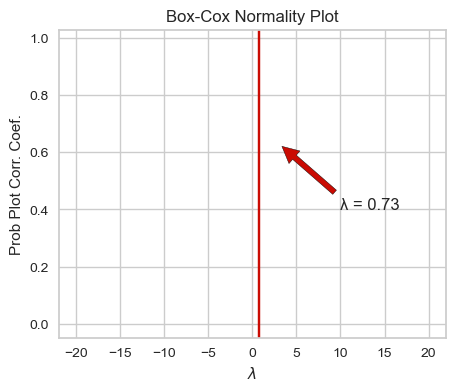

In [14]:
from scipy.stats import boxcox, boxcox_normplot
from dfply import *

df = df >> filter_by(X['Billing Amount'] > 0)
bill_amt = df['Billing Amount']

fig = plt.figure(figsize=(5, 4))
ax = fig.add_subplot(111)
prob = boxcox_normplot(bill_amt, -20, 20, plot=ax)

_, maxlog = boxcox(bill_amt.values)
ax.axvline(maxlog, color='r')
ax.annotate(
    f'λ = {maxlog:.2f}', 
    xy=(3, .63),
    xytext=(10, .4),
    arrowprops=dict(facecolor='r', shrink=0.05)
)

plt.show()

## Testa hipótese de normalidade

In [15]:
from sklearn.utils import resample
from scipy.stats import normaltest, shapiro

bill_col = [c for c in df.select_dtypes(include=['float']).columns.ravel()][0]

for nrepeat in range(10):
    new_sample = resample(df[bill_col], n_samples=100)
    _ , p_value = normaltest(new_sample)

    if p_value > 0.05:
        print(f'Dados dentro da normalidade -> {p_value}')
    else:
        print(f'Dados fora da normalidade -> {p_value}')

Dados fora da normalidade -> 3.206045968320657e-05
Dados fora da normalidade -> 0.0020394390511203407
Dados fora da normalidade -> 2.468587408460501e-08
Dados fora da normalidade -> 8.43905582491284e-06
Dados fora da normalidade -> 5.031832211454764e-05
Dados fora da normalidade -> 3.50680249028405e-06
Dados fora da normalidade -> 4.691738970739785e-08
Dados fora da normalidade -> 5.1214992451661515e-12
Dados fora da normalidade -> 4.705587704554662e-05
Dados fora da normalidade -> 0.0006850026575887756


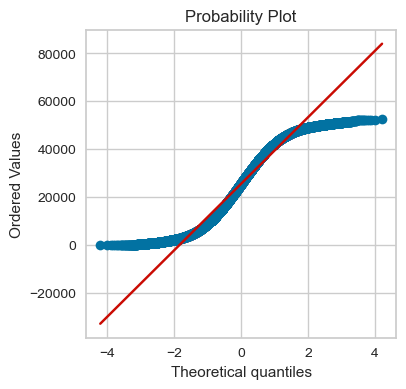

In [16]:
from scipy.stats import probplot

fig, ax = plt.subplots(figsize=(4, 4))
qq_plot = probplot(df[bill_col], plot=ax)
plt.show()

In [17]:
# Contagem de condições médicas

med_cond = df.groupby(['Medical Condition']).size().sort_values(ascending=False)
med_cond

Medical Condition
Arthritis       9207
Diabetes        9197
Hypertension    9131
Obesity         9127
Cancer          9121
Asthma          9077
dtype: int64

In [18]:
insurance = df.groupby(['Insurance Provider']).size().nlargest(3).sort_values(ascending=False)
insurance

Insurance Provider
Cigna               11115
Medicare            11018
UnitedHealthcare    10995
dtype: int64

In [19]:
admission_type = df.groupby(['Admission Type']).size().sort_values(ascending=False)
admission_type

Admission Type
Elective     18437
Urgent       18353
Emergency    18070
dtype: int64

In [20]:
test_result = df.groupby(['Test Results']).size().sort_values(ascending=False)
test_result

Test Results
Abnormal        18399
Normal          18302
Inconclusive    18159
dtype: int64

In [21]:
# Periodo de internação dos pacientes (days)

df['Period'] = df['Discharge Date'] - df['Date of Admission']

In [22]:
randint = np.random.choice(np.arange(len(df)), size=5)

df.iloc[randint][['Period']]

,Period
23505,25 days
1994,17 days
23516,8 days
40857,15 days
53579,19 days


In [23]:
period_counts = df['Period'].value_counts()
period_counts

Period
21 days    1939
20 days    1889
6 days     1887
14 days    1883
11 days    1870
19 days    1863
7 days     1859
27 days    1856
9 days     1853
30 days    1848
25 days    1847
4 days     1844
29 days    1843
13 days    1841
23 days    1840
28 days    1829
2 days     1825
3 days     1823
12 days    1820
5 days     1817
1 days     1807
8 days     1803
26 days    1796
18 days    1796
17 days    1786
10 days    1783
15 days    1769
22 days    1764
16 days    1743
24 days    1737
Name: count, dtype: int64

In [24]:
med_data = sorted(np.array(['Medical Condition', 'Hospital', 'Medication', 'Period', 'Test Results',
                           'Admission Type', 'Doctor', 'Gender']))

hosp = df[med_data].loc[
            (df['Period'] >= pd.Timedelta('10 days')) & 
            (df['Period'] <= pd.Timedelta('21 days'))
            ].sort_values(by='Period', ascending=False)
hosp

,Admission Type,Doctor,Gender,Hospital,Medical Condition,Medication,Period,Test Results
6306,Urgent,Rachel Potter,Female,"Fuentes, Williams and Flores",Obesity,Ibuprofen,21 days,Inconclusive
52583,Emergency,Angela Mitchell,Male,LLC Moon,Cancer,Lipitor,21 days,Normal
43635,Elective,Adrienne Barry,Female,"Wood, Lynch Smith and",Cancer,Ibuprofen,21 days,Abnormal
52219,Emergency,Amy Fields,Male,Nolan Inc,Cancer,Ibuprofen,21 days,Abnormal
25032,Elective,Jeffrey Nichols,Female,"Diaz Peterson, Stevenson and",Hypertension,Penicillin,21 days,Abnormal
...,...,...,...,...,...,...,...,...
29981,Urgent,Todd Jackson,Male,Mcgrath and Sons,Obesity,Ibuprofen,10 days,Inconclusive
30003,Emergency,Julie Medina,Male,Humphrey-Sharp,Arthritis,Ibuprofen,10 days,Abnormal
13277,Emergency,Katrina Lopez,Male,Group Sanchez,Obesity,Ibuprofen,10 days,Inconclusive
48865,Urgent,Dale Stewart,Female,"Hanson and Robinson, Edwards",Asthma,Aspirin,10 days,Inconclusive


In [25]:
df[df['Period'] == pd.Timedelta('21 days')].apply(lambda z: z.value_counts().idxmax() if z.notna().any() else None)

Name                       Daniel Johnson
Age                                    80
Gender                             Female
Blood Type                            AB-
Medical Condition            Hypertension
Date of Admission     2020-11-03 00:00:00
Doctor                    Michael Johnson
Hospital                        Ltd Smith
Insurance Provider       UnitedHealthcare
Billing Amount               36028.858769
Room Number                           258
Admission Type                  Emergency
Discharge Date        2020-11-24 00:00:00
Medication                        Aspirin
Test Results                 Inconclusive
Period                   21 days 00:00:00
dtype: object

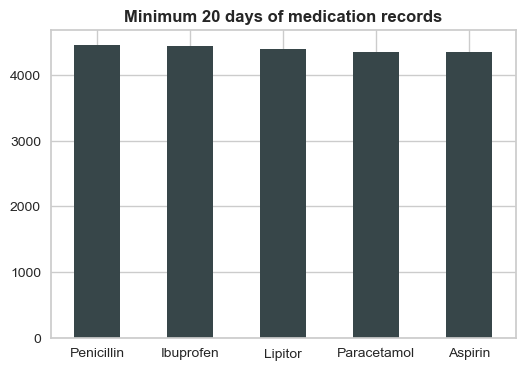

In [26]:
hosp_med_count = hosp['Medication'].value_counts()

fig = plt.figure(figsize=(6, 4))
ax = hosp_med_count.plot(kind='bar', color='#374649')

ax.set_title(f'Minimum 20 days of medication records', fontweight='bold')
ax.set_xlabel('')
ax.set_xticklabels(hosp_med_count.index, rotation=0)
plt.show()

In [27]:
# Causas mais recorrentes de internação para cada período

hosp[hosp['Medication'] == 'Penicillin'].groupby('Period').agg({
    'Hospital': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'Doctor': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'Gender': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'Medical Condition': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'Admission Type': lambda x: x.mode().iloc[0] if not x.mode().empty else None,
    'Test Results': lambda x: x.mode().iloc[0] if not x.mode().empty else None
})

,Hospital,Doctor,Gender,Medical Condition,Admission Type,Test Results
Period,,,,,,
10 days,Alvarez Ltd,Gary Miller,Male,Arthritis,Elective,Normal
11 days,Allen-Mueller,Andrea Payne,Female,Cancer,Elective,Inconclusive
12 days,Smith Group,Karen Jensen,Male,Diabetes,Elective,Abnormal
13 days,Barker-Ochoa,Andrew Williams,Female,Cancer,Elective,Inconclusive
14 days,Group Holmes,Amanda Lee,Female,Obesity,Elective,Normal
15 days,Baker-Jones,Adrian Dickson,Male,Obesity,Emergency,Inconclusive
16 days,Anderson LLC,Alan Ritter,Female,Asthma,Emergency,Abnormal
17 days,Austin LLC,Alex Dominguez,Female,Asthma,Emergency,Inconclusive
18 days,Klein Inc,Alan Long,Female,Diabetes,Urgent,Abnormal


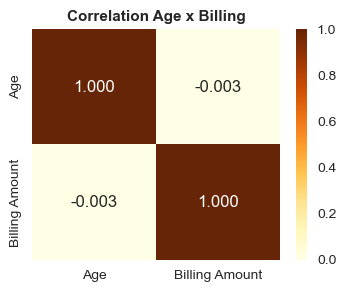

In [28]:
corr_xy = df[['Age', 'Billing Amount']].corr()
plt.figure(figsize=(4, 3))
ax = sns.heatmap(corr_xy, annot=True, fmt='.3f', cmap='YlOrBr')

plt.title(f'Correlation Age x Billing', fontsize=11, fontweight='bold')
plt.show()

In [29]:
df['billing_bin'] = pd.qcut(
    df['Billing Amount'].rank(method='first'),
    q=10, labels=False, duplicates='drop'
)

In [30]:
from sklearn.linear_model import LinearRegression
from yellowbrick.regressor import ResidualsPlot
import statsmodels.formula.api as smf

X = df.loc[:, ['Age']].values.reshape(-1, 1)
y = df[bill_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=.2,
                                                   random_state=0,
                                                   stratify=df['billing_bin'])

In [31]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return mae, rmse, r2

results = []

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('linear_model', LinearRegression())
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)
mae, rmse, r2 = evaluate(y_test, y_pred_lr)

results.append({'model':'LinearRegression','MAE':mae,'RMSE':rmse,'R2':r2})

In [33]:
from sklearn.linear_model import HuberRegressor

pipe_huber = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('huber', HuberRegressor())
])
pipe_huber.fit(X_train, y_train)
y_pred_huber = pipe_huber.predict(X_test)
mae, rmse, r2 = evaluate(y_test, y_pred_huber)

results.append({'model': 'HuberRegressor', 'MAE': mae, 'RMSE': rmse, 'R2': r2})

In [34]:
results_df = pd.DataFrame(results).set_index('model')

In [35]:
results_df.head()

,MAE,RMSE,R2
model,,,
LinearRegression,12295.431134,14196.926649,-0.000137
HuberRegressor,12295.654468,14197.097447,-0.000161


In [36]:
# Definir o melhor modelo

best_model = results_df["RMSE"].idxmin()
print("\nMelhor modelo (por RMSE):", best_model)


Melhor modelo (por RMSE): LinearRegression


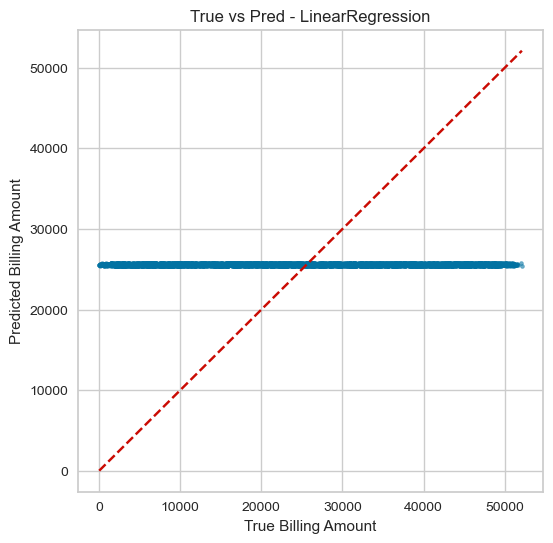

In [37]:
plt.figure(figsize=(6,6))

plt.scatter(y_test, y_pred_lr, s=8, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("True Billing Amount")
plt.ylabel("Predicted Billing Amount")
plt.title(f"True vs Pred - {best_model}")
plt.show()

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


cat_cols = [cat for cat in df.select_dtypes(include='object').columns.to_numpy().ravel()
           if cat not in ['Name', 'Test Results']]

In [39]:
for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [40]:
X = df.loc[:, cat_cols].values
y = df['Test Results']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,
                                                   random_state=42)

In [41]:
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)

DecisionTreeClassifier()

In [42]:
df_feat_imp = pd.DataFrame(tree.feature_importances_, index=cat_cols, columns=['feature_importance'])
df_feat_imp

,feature_importance
Gender,0.028612
Blood Type,0.107304
Medical Condition,0.098241
Doctor,0.286698
Hospital,0.278473
Insurance Provider,0.078401
Admission Type,0.044851
Medication,0.077420


In [47]:
from sklearn.metrics import accuracy_score

estimators = {
    'tree': DecisionTreeClassifier,
    'random forest': RandomForestClassifier,
    'naive bayes': GaussianNB,
    'neighbors': KNeighborsClassifier
}

accuracies = {}
for name, model in estimators.items():
    m = model()

    try:
        m.fit(X_train, y_train)
        y_pred = m.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[name] = round(acc, 2)
    except Exception as e:
        print(f'❌ Erro: {e}')

In [50]:
accuracies

{'tree': 0.43, 'random forest': 0.43, 'naive bayes': 0.33, 'neighbors': 0.37}

In [53]:
df_outcome = pd.DataFrame({
    'y_true': y_test,
    'y_pred': y_pred,
})

df_outcome.head()

,y_true,y_pred
53540,Normal,Abnormal
19040,Abnormal,Inconclusive
26733,Abnormal,Abnormal
51885,Normal,Inconclusive
14974,Abnormal,Abnormal


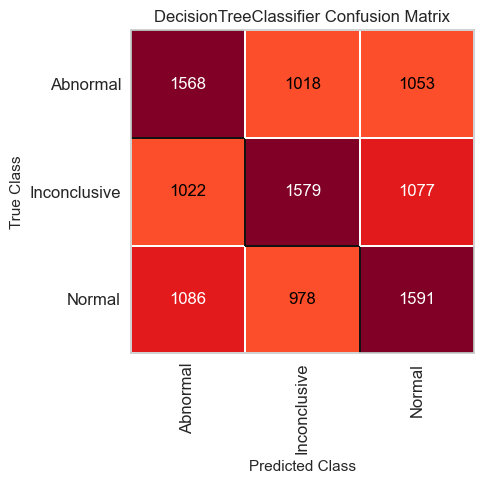

<Axes: title={'center': 'DecisionTreeClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [61]:
plt.figure(figsize=(5, 5))

conf = ConfusionMatrix(DecisionTreeClassifier())
conf.fit(X_train, y_train)
conf.score(X_test, y_test)
conf.poof()

1. **Acertos (diagonal principal)**
   * Anormal: 1.568 predições corretas.
   * Inconclusivo: 1.579 predições corretas.
   * Normal: 1.591 predições corretas.

2. **Erros (valores fora da diagonal)**
   * 1.018 instâncias de _Anormal_ foram previstas como _Inconclusivo_, e 1.053 como _Normal_.
   * _Inconclusivo_ foi confundido tanto com _Anormal_ (1.022) quanto com _Normal_ (1.077).
   * _Normal_ também se mistura com outras duas classes (1.086 e 978).

3. **Resumo**
   * O modelo consegue algum nível de balanceamento, mas a taxa de confusão é alta.
   * Como o número de erros é próximo ao de acertos, o modelo não tem capacidade discriminativa suficiente

In [62]:
acerto = 0
erro = 0

for y_real, y_prediction in zip(df_outcome['y_true'], df_outcome['y_pred']):
    if y_real == y_prediction:
        acerto+=1
    else:
        erro+=1

print('Acertos: {} \nErros: {}'.format(acerto, erro))

Acertos: 4052 
Erros: 6920


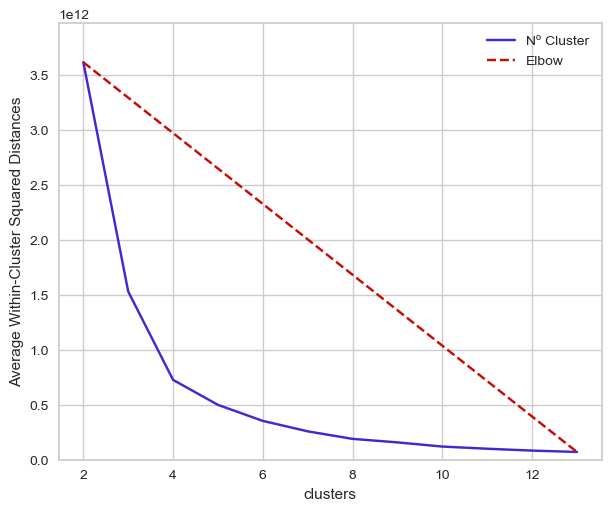

In [63]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

inertia = []
for k in range(2, 14):
    kmeans = KMeans(n_clusters=k, n_init='auto', random_state=0).fit(X_train)
    inertia.append(kmeans.inertia_ / k)

df_inertia = pd.DataFrame({
    'n_clusters': range(2, 14),
    'inertia': inertia
})
    
x1, y1 = 2, inertia[0]
x2, y2 = 13, inertia[-1]
fig, ax = plt.subplots(figsize=(6, 5), layout='constrained')

ax.plot(df_inertia['n_clusters'], df_inertia['inertia'], color='#4626cf', label=f'Nº Cluster')
plt.plot([x1, x2], [y1, y2], 'r--', label=f'Elbow')
ax.set_xlabel(f'clusters')
ax.set_ylabel(f'Average Within-Cluster Squared Distances')
ax.set_ylim(0, 1.1 * df_inertia['inertia'].max())
plt.legend().set_visible(True)

plt.show()

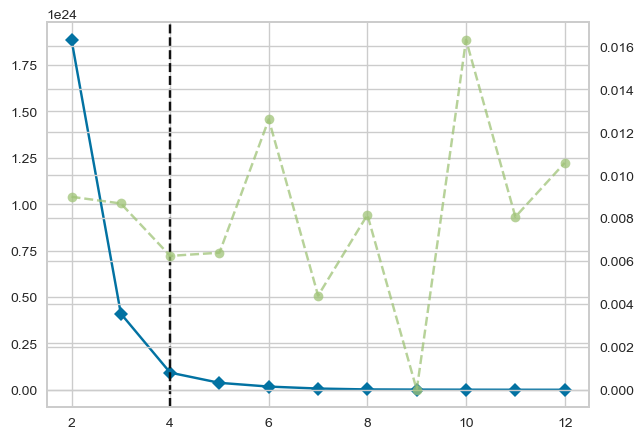

In [64]:
plt.figure(figsize=(7, 5))
elbow = KElbowVisualizer(kmeans, k=len(df_inertia))
elbow.fit(df_inertia)

plt.show()

In [65]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [66]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95, random_state=42)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[ 0.74421188, -0.47626743,  0.28856935, ...,  1.83834574,
        -0.25919046,  0.93694839],
       [ 0.45068283,  2.04625621,  1.40264499, ..., -0.72969065,
        -0.20931926, -0.18265691],
       [ 0.37022933,  0.54138586,  1.39381339, ...,  0.34034564,
        -0.1206875 , -1.85895204],
       ...,
       [-0.46492321,  0.50318583,  0.8020257 , ...,  0.33097614,
        -1.40939508, -1.82950135],
       [-1.12856855,  0.50169806,  1.48919101, ..., -1.04257898,
         0.95338582,  0.53384237],
       [ 0.41083784,  1.03054852,  0.0447199 , ...,  0.57409035,
        -1.04949528, -0.42332772]])

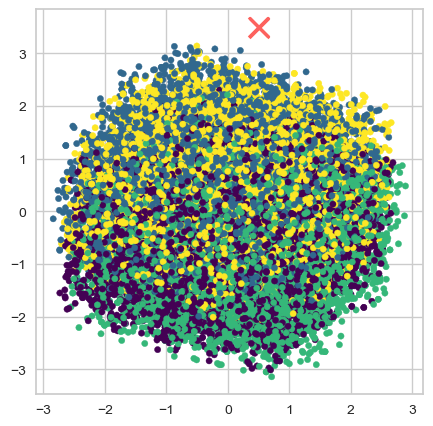

In [67]:
X_plot = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
k = KMeans(n_clusters=elbow.elbow_value_, n_init='auto').fit(X_train)

clusters = k.labels_
centroids = k.cluster_centers_

fig = plt.figure(figsize=(5, 5))
plt.scatter(
    X_plot[:, 0],
    X_plot[:, 1], 
    c=clusters,
    s=20, 
    cmap='viridis'
)
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker='x',
    s=200,
    color='#FD625E'
)

plt.show()